# End-to-end Multi-calss Dog Breed Classification

This notebook builds an end-to-end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub.

## 1. Problem

Identifying the breed of a dog given an image of a dog. 

## 2. Data

The data we are using is from Kaggle's dog breed identification competition. 

## 3. Evaluation

The evaluationp is a file with prediction probabilites for each dog breed of each test image.

## 4. Features

Some information about the data 
* Unstructured data -> Deep learning/transfer learning
* 120 breeds of dogs -> 120 different classes.
* 10000+ images in the training set
* 10000+ images in the test set

### Get our workspace ready

In [ ]:
!unzip "drive/My Drive/Dog Vision/train.zip" -d "drive/My Drive/Dog Vision/train"

Streaming output truncated to the last 5000 lines.
  inflating: drive/My Drive/Dog Vision/train/train/ce31f66a9991f1f2bb45b84b5a7bd6e7.jpg  
  inflating: drive/My Drive/Dog Vision/train/__MACOSX/train/._ce31f66a9991f1f2bb45b84b5a7bd6e7.jpg  
  inflating: drive/My Drive/Dog Vision/train/train/28f673b778e6f4cb974dc332fcb1ee1d.jpg  
  inflating: drive/My Drive/Dog Vision/train/__MACOSX/train/._28f673b778e6f4cb974dc332fcb1ee1d.jpg  
  inflating: drive/My Drive/Dog Vision/train/train/d25a5f80d6980ae97d2941913fc1ddd6.jpg  
  inflating: drive/My Drive/Dog Vision/train/__MACOSX/train/._d25a5f80d6980ae97d2941913fc1ddd6.jpg  
  inflating: drive/My Drive/Dog Vision/train/train/82d8cd7ee08ea0d65a6ee61da1520a73.jpg  
  inflating: drive/My Drive/Dog Vision/train/__MACOSX/train/._82d8cd7ee08ea0d65a6ee61da1520a73.jpg  
  inflating: drive/My Drive/Dog Vision/train/train/55132cf806d48347350caa4a31f0126b.jpg  
  inflating: drive/My Drive/Dog Vision/train/__MACOSX/train/._55132cf806d48347350caa4a31f0126b.

In [3]:
# Import tools
import tensorflow as tf
import tensorflow_hub as hub
print("TF version:", tf.__version__)
print("TF Hub version:", hub.__version__)

# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

# Set workspace path
WS_PATH="drive/My Drive/Dog Vision/"
WS_PATH_TRAIN="drive/My Drive/Dog Vision/train/train/"

TF version: 2.9.2
TF Hub version: 0.12.0
GPU available


In [ ]:
## Getting our data ready (turning into Tensors)

In [4]:
# Checkout the labels of our data
import pandas as pd
labels_csv = pd.read_csv("drive/My Drive/Dog Vision/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


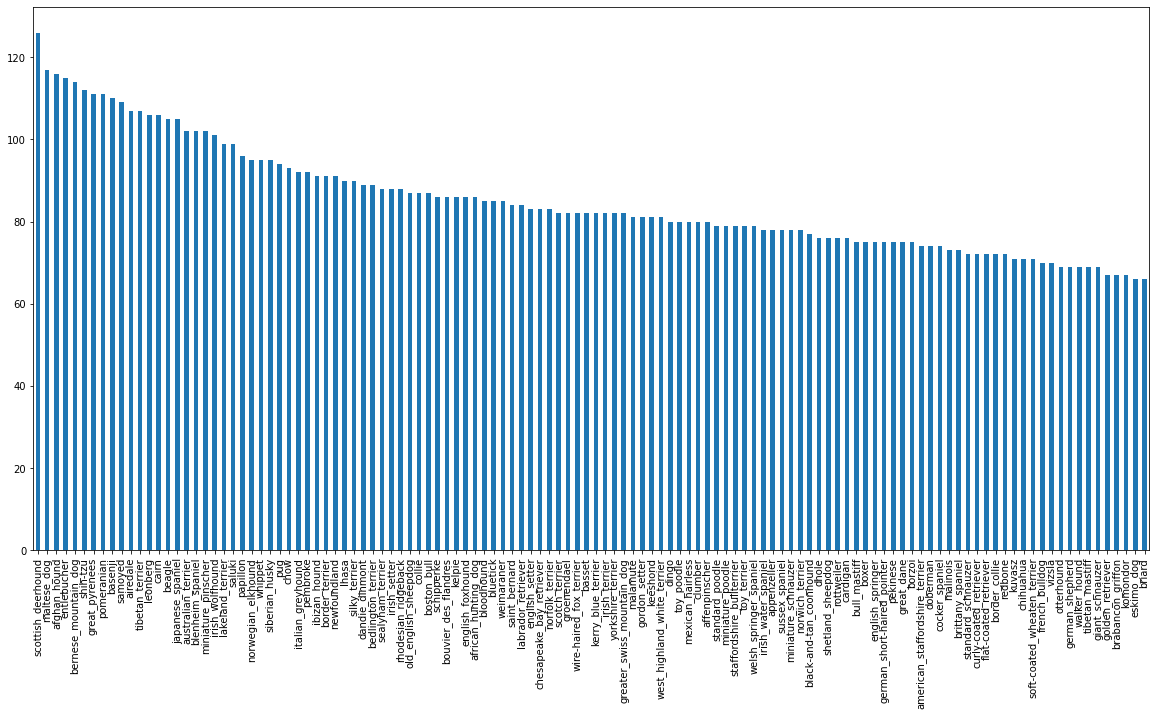

In [ ]:
# How many images are there of each breed?
labels_csv["breed"].value_counts().plot.bar(figsize=(20,10))

In [ ]:
labels_csv["breed"].value_counts().median()

82.0

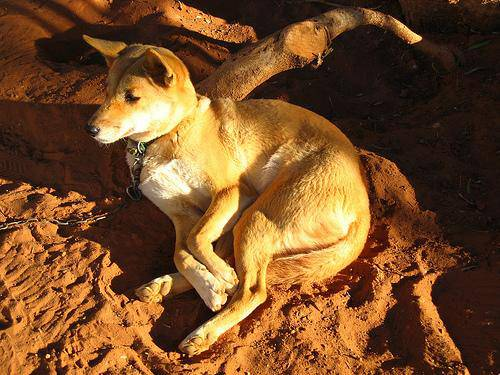

In [ ]:
# Let's view an image
from IPython.display import Image
Image("drive/My Drive/Dog Vision/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg")

### Getting images and their labels

In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
# Creat pathnames from image ID's
filenames = [WS_PATH_TRAIN + fname + ".jpg" for fname in labels_csv["id"]]
filenames[:10]

['drive/My Drive/Dog Vision/train/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/Dog Vision/train/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/Dog Vision/train/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/Dog Vision/train/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/Dog Vision/train/train/0021f9ceb3235effd7fcde7f7538ed62.jpg',
 'drive/My Drive/Dog Vision/train/train/002211c81b498ef88e1b40b9abf84e1d.jpg',
 'drive/My Drive/Dog Vision/train/train/00290d3e1fdd27226ba27a8ce248ce85.jpg',
 'drive/My Drive/Dog Vision/train/train/002a283a315af96eaea0e28e7163b21b.jpg',
 'drive/My Drive/Dog Vision/train/train/003df8b8a8b05244b1d920bb6cf451f9.jpg',
 'drive/My Drive/Dog Vision/train/train/0042188c895a2f14ef64a918ed9c7b64.jpg']

In [6]:
# Check whether number of filenames matches number of actual image files
import os
if len(os.listdir(WS_PATH_TRAIN)) == len(filenames):
  print("Filenames match actual amount of files!!! Proceed.")
else:
  print(len(os.listdir(WS_PATH_TRAIN)), len(filenames))
  print("Filenames do not match autal amount of files, check the target directory")

Filenames match actual amount of files!!! Proceed.


In [7]:
import numpy as np
labels = labels_csv["breed"].to_numpy()
labels

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [8]:
len(labels)

10222

In [ ]:
# See if number of labels matches the number of filenames
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


In [10]:
# Find the unique label values
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [11]:
# Turn a single label into an array of booleans
print(labels[0])
labels[0] == unique_breeds

boston_bull


array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False])

In [12]:
# Turn every label into a boolean array
boolean_labels = [label == unique_breeds for label in labels]
len(boolean_labels)

10222

In [13]:
# Example: Turning boolean array into integers
print(labels[0])
print(np.where(unique_breeds == labels[0]))
print(boolean_labels[0].argmax())
print(boolean_labels[0].astype(int))

boston_bull
(array([19]),)
19
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [ ]:
print(labels[2])
print(boolean_labels[2].astype(int))

pekinese
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


### Creating our own validation set

In [19]:
# Setup X & y variables
X = filenames
y = boolean_labels

In [ ]:
len(filenames)

10222

In [24]:
# Set number of images to use for experimenting
NUM_IMAGES = 1000 #@param {type: "slider", min:1000, max:10000, step: 100}

In [25]:
# Let's split our data into train and validation sets
from sklearn.model_selection import train_test_split

# Split them into training and validation of total size NUM_IMAGES
X_train, X_val, y_train, y_val = train_test_split(X[:NUM_IMAGES],
                                                  y[:NUM_IMAGES],
                                                  test_size=0.2,
                                                  random_state=42)
len(X_train), len(y_train), len(X_val), len(y_val)

(800, 800, 200, 200)

In [ ]:
# Let's have a geez at the training data
X_train[:5], y_train[:2]

(['drive/My Drive/Dog Vision/train/train/00bee065dcec471f26394855c5c2f3de.jpg',
  'drive/My Drive/Dog Vision/train/train/0d2f9e12a2611d911d91a339074c8154.jpg',
  'drive/My Drive/Dog Vision/train/train/1108e48ce3e2d7d7fb527ae6e40ab486.jpg',
  'drive/My Drive/Dog Vision/train/train/0dc3196b4213a2733d7f4bdcd41699d3.jpg',
  'drive/My Drive/Dog Vision/train/train/146fbfac6b5b1f0de83a5d0c1b473377.jpg'],
 [array([False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False,  True,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False, False, False, False,
         False, False, 

## Preprocessing Images (turning images into Tensors)

1. Take an image filepath as input
2. Use TensorFlow to read the file and save it to a variable, `image`
3. Turn our `image` (a jpg) into Tensors
4. Resize the `image` to be a shape of (224, 224)
5. Return the modified `image`

In [14]:
# Convert image to NumPy array
from matplotlib.pyplot import imread
image = imread(filenames[42])
image.shape

(257, 350, 3)

In [15]:
# Turn image into a tensor
tf.constant(image)[:2]

<tf.Tensor: shape=(2, 350, 3), dtype=uint8, numpy=
array([[[ 89, 137,  87],
        [ 76, 124,  74],
        [ 63, 111,  59],
        ...,
        [ 76, 134,  86],
        [ 76, 134,  86],
        [ 76, 134,  86]],

       [[ 72, 119,  73],
        [ 67, 114,  68],
        [ 63, 111,  63],
        ...,
        [ 75, 131,  84],
        [ 74, 132,  84],
        [ 74, 131,  86]]], dtype=uint8)>

In [16]:
# Define image size
IMG_SIZE = 224

# Create a function for preprocessing images
def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an imaeg file path and turns the image into a Tensor
  """
  # Read in an image file 
  image = tf.io.read_file(image_path)
  # Turn the jpeg image into numerical Tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image, channels=3)
  # Conver the color channel values from 0-255 to 0-1 values
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize the image to our desired value (224, 224)
  image = tf.image.resize(image, size=[img_size, img_size])
  
  return image

## Turning our data into batches

In [17]:
# Create a simple function to return a tuple (image, label)
def get_image_label(image_path, label):
  """
  Takes an image file path name and the associated label,
  processes the image and returns a type of (image, label)
  """
  image = process_image(image_path)
  return image, label

In [20]:
# Quick test
process_image(X[42]), tf.constant(y[42])

(<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
 array([[[0.3264178 , 0.5222886 , 0.3232816 ],
         [0.2537167 , 0.44366494, 0.24117757],
         [0.25699762, 0.4467087 , 0.23893751],
         ...,
         [0.29325107, 0.5189916 , 0.3215547 ],
         [0.29721776, 0.52466875, 0.33030328],
         [0.2948505 , 0.5223015 , 0.33406618]],
 
        [[0.25903144, 0.4537807 , 0.27294815],
         [0.24375686, 0.4407019 , 0.2554778 ],
         [0.2838985 , 0.47213382, 0.28298813],
         ...,
         [0.2785345 , 0.5027992 , 0.31004712],
         [0.28428748, 0.5108719 , 0.32523635],
         [0.28821915, 0.5148036 , 0.32916805]],
 
        [[0.20941195, 0.40692952, 0.25792548],
         [0.24045378, 0.43900946, 0.2868911 ],
         [0.29001117, 0.47937486, 0.32247734],
         ...,
         [0.26074055, 0.48414773, 0.30125174],
         [0.27101526, 0.49454468, 0.32096273],
         [0.27939945, 0.5029289 , 0.32934693]],
 
        ...,
 
        [[0.00634795, 0.03442048

In [26]:
# Define the batch size, 32 is a good start
BATCH_SIZE = 32

# Create a function to turn data into batches
def create_data_batches(X, y=None, batch_size=BATCH_SIZE, valid_data=False, test_data=False):
  """
  Create batches of data out of image (X) and and label (y) paris
  Shuffles the data if it's training data but does not shuffle if it's validation data/
  Also accepts test data as input (no labels)
  """
  # If the data is a test dataset, we probable don't have labels
  if test_data:
    print("Creating test data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X))) # Only filepaths (no labels)
    data_batch = data.map(process_image).patch(BATCH_SIZE)
    return data_batch

  # If the data is a valid dataset, we do not need to shuffle it
  elif valid_data:
    print("Creating validation data batches...")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), # filepaths
                                               tf.constant(y))) #labels
    data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

  else: 
    print("Creating training data batches...")
    # Turn filepaths and labels into Tensors
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X),
                                               tf.constant(y)))
    # Shuffling pathnames and labels before mapping image processor function
    data = data.shuffle(buffer_size=len(X))

    # Create (image, label) tuples (this also turns the image path into a preprocessed image)
    data = data.map(get_image_label)

    # Turn the training data into batches
    data_batch = data.batch(BATCH_SIZE)
  return data_batch

In [27]:
# Create training and validation data batches
train_data = create_data_batches(X_train, y_train)
val_data = create_data_batches(X_val, y_val, valid_data=True)

Creating training data batches...
Creating validation data batches...


In [28]:
# Checkout the different attributes of our data batches
train_data.element_spec, val_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

In [29]:
## Visualizing Data Batches

import matplotlib.pyplot as plt

# Create a function for viewing images in a data batch
def show_25_images(images, labels):
  """
  Displays a plot of 25 images and their labels from a data batch.
  """
  # Setup the figure
  plt.figure(figsize=(10, 10))
  # Loop through 25 (for displaying 25 images)
  for i in range(25):
    # Creat subplots (5 rows, 5 columns)
    ax = plt.subplot(5, 5, i+1)
    # Display an image
    plt.imshow(images[i])
    # Add the image label as the title
    plt.title(unique_breeds[labels[i].argmax()])
    # Turn the grid lines off
    # plt.axis("off")

In [30]:
train_data

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 120), dtype=tf.bool, name=None))>

In [32]:
train_images, train_labels = next(train_data.as_numpy_iterator())
train_images, train_labels

(array([[[[0.06498366, 0.18018779, 0.14178641],
          [0.07372551, 0.1657073 , 0.12589638],
          [0.10080426, 0.17818756, 0.13133764],
          ...,
          [0.2310887 , 0.36452827, 0.26310903],
          [0.12724964, 0.30217975, 0.20130298],
          [0.2202075 , 0.4084428 , 0.30648202]],
 
         [[0.11493527, 0.22081764, 0.18552352],
          [0.13536298, 0.22734478, 0.18753386],
          [0.05461633, 0.13241746, 0.08539887],
          ...,
          [0.17261106, 0.318075  , 0.18357754],
          [0.20866503, 0.38564336, 0.27248266],
          [0.16045544, 0.34076008, 0.23099989]],
 
         [[0.0831349 , 0.18632993, 0.15103582],
          [0.05212358, 0.14288169, 0.10347866],
          [0.19920087, 0.28237665, 0.23645288],
          ...,
          [0.2640177 , 0.42430007, 0.25246602],
          [0.2423628 , 0.4066188 , 0.28579083],
          [0.1860571 , 0.35591877, 0.24734911]],
 
         ...,
 
         [[0.33418208, 0.34986836, 0.36163306],
          [0.19029

In [33]:
len(train_images), len(train_labels)

(32, 32)

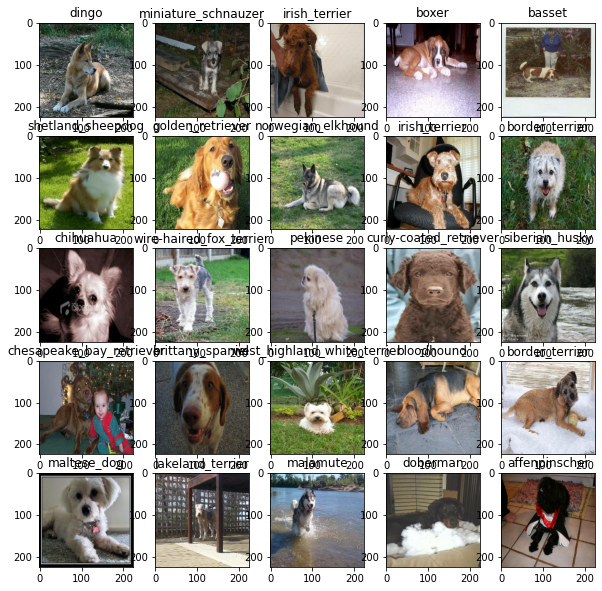

In [35]:
# Now let's visualize the data in a training batch
show_25_images(train_images, train_labels)

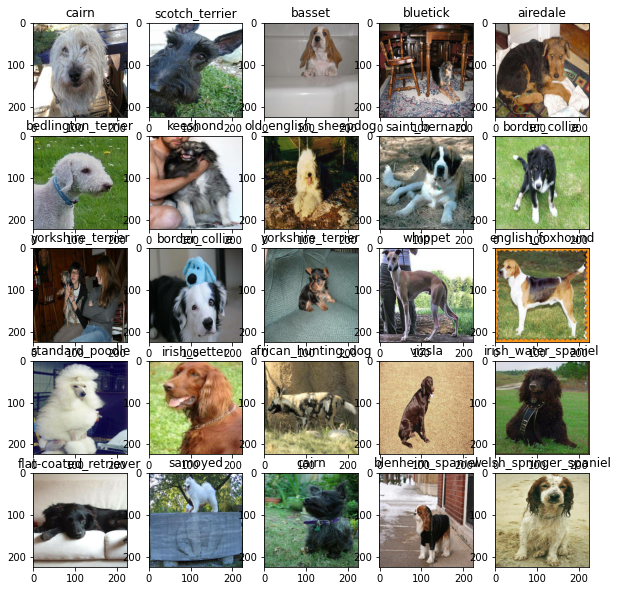

In [36]:
# Now let's visualize the data in our validation set
val_images, val_labels = next(val_data.as_numpy_iterator())
show_25_images(val_images, val_labels)

## Building a model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model. 
* The output shape (image labels, in the form of Tensors) of our model.
* The URL of the model we want to use.

In [38]:
# Setup input shape to the model
INPUT_SHAPE = [None, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, color channels

# Setup output shape of our model
OUTPUT_SHAPE = len(unique_breeds)

# Setup model URL from Tensorflow Hub
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4"

In [39]:
IMG_SIZE

224

In [43]:
# Create a function which builds a Keras model
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
  print("Building model with:", MODEL_URL)

  # Setup the model layers
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL),
      tf.keras.layers.Dense(units=OUTPUT_SHAPE,
                            activation="softmax")
  ])
  
  # Compile the model
  model.compile(
      loss=tf.keras.losses.CategoricalCrossentropy(),
      optimizer=tf.keras.optimizers.Adam(),
      metrics=["accuracy"]
  )

  # Build the model
  model.build(INPUT_SHAPE)

  return model

In [44]:
model = create_model()
model.summary()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1001)              5432713   
                                                                 
 dense_1 (Dense)             (None, 120)               120240    
                                                                 
Total params: 5,552,953
Trainable params: 120,240
Non-trainable params: 5,432,713
_________________________________________________________________


## Creating callbacks

### TensorBoard Callbacks


In [ ]:
# Load TensorBoard notebook extension
%load_ext tensorboard


In [45]:
import datetime

def create_tensorboard_callback():
  logdir = os.path.join("drive/My Drive/Dog Vision/logs",
                        datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  return tf.keras.callbacks.TensorBoard(logdir)

### Early Stopping Callback

Early stopping heps stop our model from overfitting by stoping training if a certain evaluation metrisc stopping

In [46]:
# Create early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy",
                                                  patience=3)

## Training a model (on subset of data)

Our first model is only going to train on 1000 images, to make sure everything is working

In [47]:
NUM_EPOCHS = 100 #@param {type: "slider", min:10, max:100, step:10}

In [48]:
# Check for GPU availability
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available")

GPU available


In [54]:
# Build a function to train and return a trained model
def train_model():
  """
  Trains a given model and returns the trained version.
  """
  # Create a model
  model = create_model()

  # Create new TensorBoard session everytime we train a model
  tensorboard = create_tensorboard_callback()

  # Fit the model to the data passing it the callbacks we created
  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=val_data,
            validation_freq=1,
            callbacks=[tensorboard, early_stopping])
  # Return the fitted model
  return model

In [55]:
# Fit the model to the data
model = train_model()

Building model with: https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/4
Epoch 1/100
25/25 [==============================] - 109s 4s/step - loss: 4.5250 - accuracy: 0.1125 - val_loss: 3.4524 - val_accuracy: 0.2250
Epoch 2/100
25/25 [==============================] - 4s 174ms/step - loss: 1.6369 - accuracy: 0.7237 - val_loss: 2.2536 - val_accuracy: 0.4600
Epoch 3/100
25/25 [==============================] - 4s 178ms/step - loss: 0.5659 - accuracy: 0.9413 - val_loss: 1.7364 - val_accuracy: 0.5600
Epoch 4/100
25/25 [==============================] - 4s 179ms/step - loss: 0.2479 - accuracy: 0.9900 - val_loss: 1.5529 - val_accuracy: 0.6050
Epoch 5/100
25/25 [==============================] - 5s 193ms/step - loss: 0.1451 - accuracy: 0.9962 - val_loss: 1.4552 - val_accuracy: 0.6200
Epoch 6/100
25/25 [==============================] - 4s 171ms/step - loss: 0.0995 - accuracy: 1.0000 - val_loss: 1.4161 - val_accuracy: 0.6300
Epoch 7/100
25/25 [==============================]